In [2]:
import os
import chardet
from datetime import datetime
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from IPython.display import Markdown

plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

In [3]:
os.listdir('.')

['.gitignore',
 'gun_violence_eda.ipynb',
 '.ipynb_checkpoints',
 'gun-violence-data_01-2013_03-2018.csv',
 '.git']

In [4]:
# check what the character encoding might be
with open('gun-violence-data_01-2013_03-2018.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'utf-8', 'language': '', 'confidence': 0.99}


In [5]:
df = pd.read_csv('gun-violence-data_01-2013_03-2018.csv', index_col='incident_id', parse_dates=[1])

In [6]:
 df.columns

Index(['date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured',
       'incident_url', 'source_url', 'incident_url_fields_missing',
       'congressional_district', 'gun_stolen', 'gun_type',
       'incident_characteristics', 'latitude', 'location_description',
       'longitude', 'n_guns_involved', 'notes', 'participant_age',
       'participant_age_group', 'participant_gender', 'participant_name',
       'participant_relationship', 'participant_status', 'participant_type',
       'sources', 'state_house_district', 'state_senate_district'],
      dtype='object')

In [7]:
# removing unuseful columns 
df.drop(labels=['address', 'incident_url', 'incident_url_fields_missing', 'congressional_district',
                'location_description', 'participant_name', 'sources', 'state_house_district', 
                'state_senate_district'], 
        axis=1, inplace=True)

In [8]:
df.dtypes

date                        datetime64[ns]
state                               object
city_or_county                      object
n_killed                             int64
n_injured                            int64
source_url                          object
gun_stolen                          object
gun_type                            object
incident_characteristics            object
latitude                           float64
longitude                          float64
n_guns_involved                    float64
notes                               object
participant_age                     object
participant_age_group               object
participant_gender                  object
participant_relationship            object
participant_status                  object
participant_type                    object
dtype: object

# Plot map of incidents

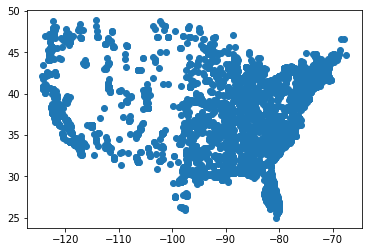

In [10]:
temp = df[['latitude', 'longitude']].copy()

# removing hawaii, alyeska and some anomalys
temp = temp.loc[temp['longitude'].between(-125, -40) & temp['latitude'].between(25, 50), :]
temp = temp.dropna().sample(10000)
plt.scatter(temp['longitude'], temp['latitude']);

# Major facts about our dataset

In [11]:
total_incidents = df.shape[0]
zero_killed_or_injured = df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0)].shape[0]

Markdown("""
### In {} thousand incidents there is {:2.0f}% injured or killed people.
""".format(total_incidents // 1000, (total_incidents - zero_killed_or_injured) * 100 / total_incidents))


### In 239 thousand incidents there is 59% injured or killed people.


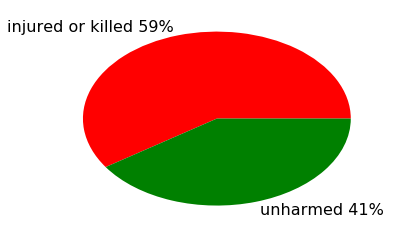

In [13]:
patches, texts = plt.pie([total_incidents - zero_killed_or_injured, zero_killed_or_injured], 
                                     labels=['injured or killed 59%', 'unharmed 41%'], colors=['r', 'g'])
texts[0].set_fontsize(16)
texts[1].set_fontsize(16)

In [14]:
df[['n_killed', 'n_injured']].describe()

,n_killed,n_injured
count,239677.000000,239677.000000
mean,0.252290,0.494007
std,0.521779,0.729952
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,50.000000,53.000000


In [15]:
temp = df['n_killed'].value_counts()\
.reset_index().rename(columns={'index': 'n_killed', 'n_killed': 'count'}).sort_values(by='n_killed')
temp['freq'] = temp['count'] / total_incidents
temp.loc[temp['freq'] >= 0.0001, ['n_killed', 'freq']]

,n_killed,freq
0,0,0.775356
1,1,0.202089
2,2,0.019209
3,3,0.002483
4,4,0.000580
5,5,0.000171


In [16]:
Markdown("""
### We can see what mass shoting (more or equal than 4 killed) is rare event it happend 1 in {:.0f} inidents
""".format( 1 / temp.loc[temp['n_killed'] >= 4, 'freq'].sum()))


### We can see what mass shoting (more or equal than 4 killed) is rare event it happend 1 in 1158 inidents


In [17]:
temp = (df['n_injured'] + df['n_killed']).value_counts().reset_index()\
.rename(columns={'index': 'n_injured_or_killed', 0: 'count'}).sort_values(by='n_injured_or_killed')
temp['freq'] = temp['count'] / total_incidents
temp.loc[temp['freq'] >= 0.001, ['n_injured_or_killed', 'freq']]

,n_injured_or_killed,freq
1,0,0.405909
0,1,0.484936
2,2,0.082586
3,3,0.017799
4,4,0.005591
5,5,0.001807


In [18]:
Markdown("""
### We can see what the most probable situation is where zero or one person injured or killed. \
Over {:.2f}% of all insidents have less or equal than 2 injured or killed person.
""".format(temp.loc[temp['n_injured_or_killed'] <= 2, 'freq'].sum()))


### We can see what the most probable situation is where zero or one person injured or killed. Over 0.97% of all insidents have less or equal than 2 injured or killed person.


In [19]:
df['date'].dt.year.value_counts()

2017    61401
2016    58763
2015    53579
2014    51854
2018    13802
2013      278
Name: date, dtype: int64

### It seems what amout of cases with guns increasing (if we drop 2013, 2018 because we don't have full data on them)

In [20]:
df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0), 'date'].dt.year.value_counts()

2017    24272
2014    23700
2016    22224
2015    21121
2018     5970
Name: date, dtype: int64

In [21]:
df.loc[~((df['n_killed'] == 0) & (df['n_injured']  == 0)), 'date'].dt.year.value_counts()

2017    37129
2016    36539
2015    32458
2014    28154
2018     7832
2013      278
Name: date, dtype: int64

### Amout of cases with injured people is also increasing

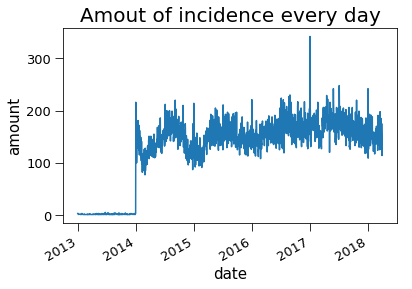

In [23]:
ax = df.groupby(by='date')['state'].count().plot()
ax.set_ylabel('amount', fontdict={'fontsize': 15})
ax.set_xlabel('date', fontdict={'fontsize': 15})
ax.tick_params(labelsize=13, length=8)
text = plt.title('Amout of incidence every day')
text.set_fontsize(20)

### 2013 is almost empty and should be ignored.

In [24]:
for year in range(2014, 2019):
    print('In {} {} unique websites were used'\
          .format(year, df.loc[df['date'].dt.year == year, 'source_url']\
                  .str.split('//').str.get(1).str.replace('^www.','').str.split('/').str.get(0).nunique()))

In 2014 2001 unique websites were used
In 2015 1900 unique websites were used
In 2016 2197 unique websites were used
In 2017 2429 unique websites were used
In 2018 1450 unique websites were used


In [25]:
for year in range(2014, 2019):
    print('In {} {} websites with more than 1 incident are used'\
          .format(year, (df.loc[df['date'].dt.year == year, 'source_url'].str.split('//')\
                  .str.get(1).str.replace('www.','').str.split('/').str.get(0)\
                  .value_counts() > 1).sum()))

In 2014 1310 websites with more than 1 incident are used
In 2015 1256 websites with more than 1 incident are used
In 2016 1515 websites with more than 1 incident are used
In 2017 1715 websites with more than 1 incident are used
In 2018 1026 websites with more than 1 incident are used


### We can see that amount of website where data is found is also increasing with time. 

In [26]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([2001, 1900, 2197, 2429])
stats.pearsonr(amount, year)

(0.9286527706898371, 0.07134722931016292)

In [27]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([1310, 1256, 1515, 1715])
stats.pearsonr(amount, year)

(0.9534795845489521, 0.046520415451047896)

### In both cases they highly correlated. But it doesn't mean that increasing of gun involved incidents can be explained by increasing of data sources.

# Work on participant features

In [41]:
df['participant_age'].head().str.extract('([\d]*)::([\d]*)', expand=True)

,0,1
incident_id,,
461105,0,20
460726,0,20
478855,0,25
478925,0,29
478959,0,18


In [ ]:
df['age_g_1']df['participant_age_group'].head().str.split('\|\|').str.get(3).str.replace('[\d]*::', '')

In [64]:
df['participant_age_group'].head().str\
.extract('[\d]*::([\d\w +]*)\|\|[\d]*::([\d\w +]*)\|\|[\d]*::([\d\w +]*)\|\|', expand=True)

,0,1,2
incident_id,,,
461105,Adult 18+,Adult 18+,Adult 18+
460726,Adult 18+,Adult 18+,Adult 18+
478855,Adult 18+,Adult 18+,Adult 18+
478925,Adult 18+,Adult 18+,Adult 18+
478959,NaN,NaN,NaN


In [92]:
df['participant_age_group'].head().str.split('\|\|').str.get(3).str.replace('[\d]*::', '')

incident_id
461105    Adult 18+
460726    Adult 18+
478855    Adult 18+
478925    Adult 18+
478959    Adult 18+
Name: participant_age_group, dtype: object

In [93]:
df['participant_gender'].head().str.split('\|\|').str.get(2).str.replace('[\d]*::', '')

incident_id
461105    Male
460726     NaN
478855    Male
478925    Male
478959    Male
Name: participant_gender, dtype: object

In [82]:
df['participant_status'].head().str.split('\|\|').str.get(3)


incident_id
461105    3::Injured
460726    3::Injured
478855    3::Injured
478925     3::Killed
478959     3::Killed
Name: participant_status, dtype: object

In [70]:
df['state'].value_counts().iloc[:10]

Illinois          17556
California        16306
Florida           15029
Texas             13577
Ohio              10244
New York           9712
Pennsylvania       8929
Georgia            8925
North Carolina     8739
Louisiana          8103
Name: state, dtype: int64

In [17]:
df['city_or_county'].value_counts().loc[df['city_or_county'].value_counts().index == 'Penn Valley']

Penn Valley    2
Name: city_or_county, dtype: int64